In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Train Data Loading

In [ ]:
train_data = pd.read_excel('../Data/train_data_prob_added.xlsx')
train_data = train_data.convert_dtypes()
test_data = pd.read_excel('../Data/test_data_prob_added.xlsx')
test_data = test_data.convert_dtypes()

In [ ]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              36168 non-null  string 
 1   age            36168 non-null  Int64  
 2   balance        36168 non-null  Int64  
 3   day_of_month   36168 non-null  Int64  
 4   duration       36168 non-null  Int64  
 5   campaign       36168 non-null  Int64  
 6   pdays          36168 non-null  Int64  
 7   previous       36168 non-null  Int64  
 8   NB_prob        36168 non-null  Float64
 9   Logistic_prob  36168 non-null  Float64
 10  DT_prob        36168 non-null  Float64
 11  EBM_prob       36168 non-null  Float64
dtypes: Float64(4), Int64(7), string(1)
memory usage: 3.7 MB
None


In [ ]:
display(train_data.head())
train_data.shape

,y,age,balance,day_of_month,duration,campaign,pdays,previous,NB_prob,Logistic_prob,DT_prob,EBM_prob
0,yes,66,2048,27,212,1,-1,0,0.2548,0.590641,0.525657,0.336438
1,no,49,181,8,161,3,-1,0,0.012788,0.184176,0.286525,0.185477
2,no,41,-129,18,176,1,-1,0,0.020337,0.460129,0.403237,0.365158
3,no,42,1316,5,285,1,-1,0,0.070662,0.283496,0.286525,0.372153
4,no,45,1621,18,122,8,-1,0,0.095399,0.416171,0.525657,0.487318


(36168, 12)

## Continuous Covariates

In [ ]:
numeric_cols = ["age","balance","pdays","previous","NB_prob","Logistic_prob","DT_prob"]
X_train = train_data[numeric_cols].copy()
X_test = test_data[numeric_cols].copy()
y_train = (train_data['y'] == "yes").astype(int)
y_test = (test_data['y'] == "yes").astype(int)

In [ ]:
X_train["log_balance"] = np.sign(X_train["balance"]) * np.log1p(np.abs(X_train["balance"]))
X_train["log_previous"] = np.log1p(X_train["previous"])
X_test["log_balance"] = np.sign(X_test["balance"]) * np.log1p(np.abs(X_test["balance"]))
X_test["log_previous"] = np.log1p(X_test["previous"])

In [ ]:
X_train.head()

,age,balance,pdays,previous,NB_prob,Logistic_prob,DT_prob,log_balance,log_previous
0,66,2048,-1,0,0.2548,0.590641,0.525657,7.625107,0.0
1,49,181,-1,0,0.012788,0.184176,0.286525,5.204007,0.0
2,41,-129,-1,0,0.020337,0.460129,0.403237,-4.867534,0.0
3,42,1316,-1,0,0.070662,0.283496,0.286525,7.183112,0.0
4,45,1621,-1,0,0.095399,0.416171,0.525657,7.391415,0.0


In [ ]:
y_train.value_counts()

y
0    31936
1     4232
Name: count, dtype: int64

In [ ]:
X_train = X_train.drop(["balance","previous"], axis=1)
X_test = X_test.drop(["balance","previous"], axis=1)

In [ ]:
X_train.columns

Index(['age', 'pdays', 'NB_prob', 'Logistic_prob', 'DT_prob', 'log_balance',
       'log_previous'],
      dtype='object')

In [ ]:
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C = 0.001, class_weight="balanced"))
])

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
print_metrics(y_test, y_pred)

Confusion Matrix:
 [[6838 1148]
 [ 487  570]]

Classification Report:
               precision    recall  f1-score   support

           0      0.934     0.856     0.893      7986
           1      0.332     0.539     0.411      1057

    accuracy                          0.819      9043
   macro avg      0.633     0.698     0.652      9043
weighted avg      0.863     0.819     0.837      9043



In [ ]:
X_train.shape

(36168, 7)

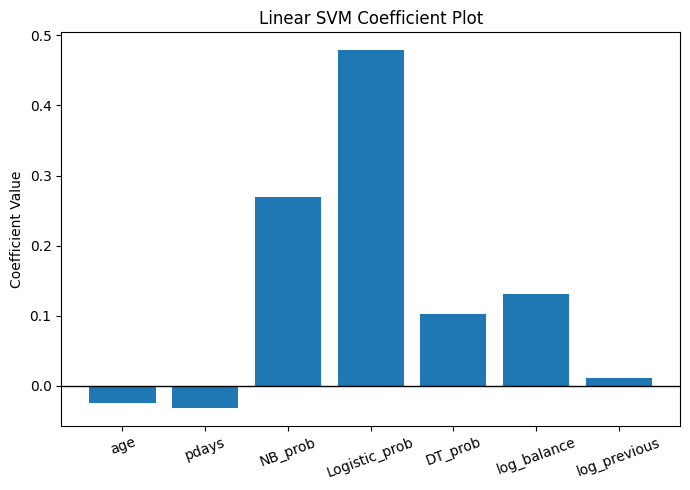

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients
coef = svm_model.named_steps["svc"].coef_[0]

plt.figure(figsize=(7,5))
plt.bar(list(X_train.columns), coef)
plt.axhline(0, color='black', linewidth=1)
plt.title("Linear SVM Coefficient Plot")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [ ]:
# Coefficient vector w
w = svm_model.named_steps["svc"].coef_[0]

# Margin width
margin = 2 / np.linalg.norm(w)

print("Margin width:", margin)


Margin width: 3.473996327549503


In [ ]:
import plotly.graph_objects as go
import numpy as np

scaler = svm_model.named_steps["scaler"]
svc = svm_model.named_steps["svc"]

def plot_linear_boundary_plotly(i, j, X, y, model, save_path="plots/"):
    import os
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    var_i = X.columns[i]
    var_j = X.columns[j]

    xi = X[var_i].values
    xj = X[var_j].values

    w = model.coef_[0]
    b = model.intercept_[0]

    wi = w[i]
    wj = w[j]

    # meshgrid + padding
    x_min, x_max = xi.min(), xi.max()
    y_min, y_max = xj.min(), xj.max()

    range_x = x_max - x_min
    range_y = y_max - y_min

    x_min, x_max = x_min - 0.1 * range_x, x_max + 0.1 * range_x
    y_min, y_max = y_min - 0.1 * range_y, y_max + 0.1 * range_y

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    zz = (wi * xx + wj * yy + b)

    fig = go.Figure()

    # pretty shaded half-spaces
    fig.add_trace(go.Contour(
        z=zz,
        x=np.linspace(x_min, x_max, 200),
        y=np.linspace(y_min, y_max, 200),
        showscale=False,
        colorscale=[
            [0.0, 'rgba(244, 143, 177, 0.33)'],  # pink
            [1.0, 'rgba(129, 212, 250, 0.33)']   # teal
        ],
        contours=dict(start=0, end=0, size=1),
        hoverinfo='skip'
    ))

    # decision boundary line
    xx_line = np.linspace(x_min, x_max, 200)
    yy_line = -(wi / wj) * xx_line - b / wj
    fig.add_trace(go.Scatter(
        x=xx_line,
        y=yy_line,
        mode='lines',
        line=dict(color='#37474F', width=3),
        name='Decision Boundary'
    ))

    # separate class points for legend
    class0_mask = (y == 0)
    class1_mask = (y == 1)
    
    # Class 1 = Teal
    fig.add_trace(go.Scatter(
        x=xi[class1_mask],
        y=xj[class1_mask],
        mode='markers',
        marker=dict(
            size=8,
            color='#00796B',
            line=dict(width=0.2, color='white'),
            opacity=0.7,
        ),
        name='Yes'
    ))

    # Class 0 = Orange
    fig.add_trace(go.Scatter(
        x=xi[class0_mask],
        y=xj[class0_mask],
        mode='markers',
        marker=dict(
            size=8,
            color='#E64A19',
            line=dict(width=0.2, color='white'),
            opacity=0.7,
        ),
        name='No'
    ))

    # layout
    fig.update_layout(
        title=dict(
            text=f"Linear SVM Hyperplane: {var_i} vs {var_j}",
            x=0.5,
            xanchor='center',
            font=dict(family='Bahnschrift', size=20)
        ),
        xaxis_title=var_i,
        yaxis_title=var_j,
        template='plotly_white',
        width=750,
        height=520,
        showlegend=True,
        legend=dict(
            x=0.02, y=0.98,
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor="LightGray",
            borderwidth=1,
            font=dict(family='Bahnschrift', size=12)
        ),
        margin=dict(l=60, r=60, t=80, b=60),
        font=dict(family='Bahnschrift', size=14),
        xaxis=dict(
            showgrid=True,
            gridcolor='lightgray',
            zeroline=False,
            title_font=dict(family='Bahnschrift', size=16),
            tickfont=dict(family='Bahnschrift', size=12)
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='lightgray',
            zeroline=False,
            title_font=dict(family='Bahnschrift', size=16),
            tickfont=dict(family='Bahnschrift', size=12)
        )
    )

    # save
    filename = f"{save_path}SVM_{var_i}_vs_{var_j}.png"
    fig.write_image(filename, scale=2)
    print(f"Saved: {filename}")


# loop pairs and save
for i, j in [(2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]:
    plot_linear_boundary_plotly(i, j, X_test, y_test, svc)

Saved: plots/SVM_NB_prob_vs_Logistic_prob.png
Saved: plots/SVM_NB_prob_vs_DT_prob.png
Saved: plots/SVM_NB_prob_vs_log_balance.png
Saved: plots/SVM_Logistic_prob_vs_DT_prob.png
Saved: plots/SVM_Logistic_prob_vs_log_balance.png
Saved: plots/SVM_DT_prob_vs_log_balance.png


In [ ]:
X_test.columns

Index(['age', 'pdays', 'NB_prob', 'Logistic_prob', 'DT_prob', 'log_balance',
       'log_previous'],
      dtype='object')

In [ ]:
import plotly.graph_objects as go
import numpy as np

scaler = svm_model.named_steps["scaler"]
svc = svm_model.named_steps["svc"]

def plot_linear_boundary_plotly(i, j, X, y, model, save_path="plots/"):
    import os
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    var_i = X.columns[i]
    var_j = X.columns[j]

    xi = X[var_i].values
    xj = X[var_j].values

    w = model.coef_[0]
    b = model.intercept_[0]

    wi = w[i]
    wj = w[j]

    # meshgrid + padding
    x_min, x_max = xi.min(), xi.max()
    y_min, y_max = xj.min(), xj.max()

    range_x = x_max - x_min
    range_y = y_max - y_min

    x_min, x_max = x_min - 0.1 * range_x, x_max + 0.1 * range_x
    y_min, y_max = y_min - 0.1 * range_y, y_max + 0.1 * range_y

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    zz = (wi * xx + wj * yy + b)

    fig = go.Figure()

    # pretty shaded half-spaces
    fig.add_trace(go.Contour(
        z=zz,
        x=np.linspace(x_min, x_max, 200),
        y=np.linspace(y_min, y_max, 200),
        showscale=False,
        colorscale=[
            [0.0, 'rgba(244, 143, 177, 0.33)'],  # pink
            [1.0, 'rgba(129, 212, 250, 0.33)']   # teal
        ],
        contours=dict(start=0, end=0, size=1),
        hoverinfo='skip'
    ))

    # decision boundary line
    xx_line = np.linspace(x_min, x_max, 200)
    yy_line = -(wi / wj) * xx_line - b / wj
    fig.add_trace(go.Scatter(
        x=xx_line,
        y=yy_line,
        mode='lines',
        line=dict(color='#37474F', width=3),
        name='Decision Boundary'
    ))

    # separate class points for legend
    class0_mask = (y == 0)
    class1_mask = (y == 1)
    
    # Class 1 = Teal
    fig.add_trace(go.Scatter(
        x=xi[class1_mask],
        y=xj[class1_mask],
        mode='markers',
        marker=dict(
            size=8,
            color='#00796B',
            line=dict(width=0.2, color='white'),
            opacity=0.7,
        ),
        name='Yes'
    ))

    # Class 0 = Orange
    fig.add_trace(go.Scatter(
        x=xi[class0_mask],
        y=xj[class0_mask],
        mode='markers',
        marker=dict(
            size=8,
            color='#E64A19',
            line=dict(width=0.2, color='white'),
            opacity=0.7,
        ),
        name='No'
    ))

    # layout
    fig.update_layout(
        title=dict(
            text=f"Linear SVM Hyperplane: {var_i} vs {var_j}",
            x=0.5,
            xanchor='center',
            font=dict(family='Bahnschrift', size=20)
        ),
        xaxis_title=var_i,
        yaxis_title=var_j,
        template='plotly_white',
        width=750,
        height=520,
        showlegend=True,
        legend=dict(
            x=0.02, y=0.98,
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor="LightGray",
            borderwidth=1,
            font=dict(family='Bahnschrift', size=12)
        ),
        margin=dict(l=60, r=60, t=80, b=60),
        font=dict(family='Bahnschrift', size=14),
        xaxis=dict(
            showgrid=True,
            gridcolor='lightgray',
            range = [0,1],
            zeroline=False,
            title_font=dict(family='Bahnschrift', size=16),
            tickfont=dict(family='Bahnschrift', size=12)
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='lightgray',
            range = [0.1,1],
            zeroline=False,
            title_font=dict(family='Bahnschrift', size=16),
            tickfont=dict(family='Bahnschrift', size=12)
        )
    )

    # save
    filename = f"{save_path}SVM_{var_i}_vs_{var_j}.png"
    fig.write_image(filename, scale=2)
    print(f"Saved: {filename}")


# loop pairs and save
i = 3
j = 4
plot_linear_boundary_plotly(i, j, X_test, y_test, svc)

Saved: plots/SVM_Logistic_prob_vs_DT_prob.png
